## Step 1: Load CSV

Load CSV

In [30]:
%matplotlib inline


In [1]:
# --- Minimal loader for Telco datasets ---
from pathlib import Path
import pandas as pd

# 1) Point to your repo root (adjust only if your path is different)
ROOT = Path(r"C:\Users\miga\Documents\GitHub\Project_EDSB")
DATA_RAW = ROOT / "data" / "raw"
print("DATA_RAW:", DATA_RAW)

# 2) Files to load
files = {
    "demographics": "Telco_customer_churn_demographics.csv",
    "location":     "Telco_customer_churn_location.csv",
    "population":   "Telco_customer_churn_population.csv",
    "services":     "Telco_customer_churn_services.csv",
    "status":       "Telco_customer_churn_status.csv",
}

# 3) Read (auto-detects comma vs semicolon) + sanity checks
dfs = {}
for name, fname in files.items():
    path = DATA_RAW / fname
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    df = pd.read_csv(path, sep=None, engine="python", encoding="utf-8-sig")
    dfs[name] = df

# 4) Show shapes + full column names (short, no truncation)
for name, df in dfs.items():
    print(f"\n{name}: {df.shape}")
    print(df.columns.tolist())

# Optional: keep as variables for later steps
demographics = dfs["demographics"]
location     = dfs["location"]
population   = dfs["population"]
services     = dfs["services"]
status       = dfs["status"]





DATA_RAW: C:\Users\miga\Documents\GitHub\Project_EDSB\data\raw

demographics: (7043, 9)
['Customer ID', 'Count', 'Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married', 'Dependents', 'Number of Dependents']

location: (7043, 9)
['Customer ID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude']

population: (1671, 3)
['ID', 'Zip Code', 'Population']

services: (7043, 30)
['Customer ID', 'Count', 'Quarter', 'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Avg Monthly GB Download', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue']

status

## Step 2: Initial Data Exploration and Light Cleaning
- Let's explore each dataset individually first using pandas profiling 

In [13]:
%pip install ydata-profiling

In [14]:
# Set up reports folder

from pathlib import Path

# ROOT should already exist from your previous cell.
# If not, uncomment and set it:
# ROOT = Path(r"C:/Users/Miguel/Documents/GitHub/Project_EDS")

REPORTS_DIR = ROOT / "reports" / "profiling_raw_tables"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print("Reports will be saved to:", REPORTS_DIR)


Reports will be saved to: C:\Users\miga\Documents\GitHub\Project_EDSB\reports\profiling_raw_tables


In [15]:
# Generate YData Profiling reports for each raw table

from ydata_profiling import ProfileReport

def create_profile(df, name: str, output_dir: Path = REPORTS_DIR):
    """
    Generate a YData Profiling HTML report for a dataframe.
    """
    print(f"🔍 Creating profile for: {name} ...")
    profile = ProfileReport(
        df,
        title=f"Telco Customer Churn – {name} table",
        explorative=True,     # richer report
        minimal=False
    )
    output_path = output_dir / f"{name}_profiling.html"
    profile.to_file(output_path)
    print(f"✅ Saved: {output_path}\n")

# If dfs was created in Step 1, it should contain:
# 'demographics', 'location', 'population', 'services', 'status'
for name, df in dfs.items():
    create_profile(df, name)


🔍 Creating profile for: demographics ...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 10.65it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Saved: C:\Users\miga\Documents\GitHub\Project_EDSB\reports\profiling_raw_tables\demographics_profiling.html

🔍 Creating profile for: location ...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 124.49it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Saved: C:\Users\miga\Documents\GitHub\Project_EDSB\reports\profiling_raw_tables\location_profiling.html

🔍 Creating profile for: population ...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 752.57it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Saved: C:\Users\miga\Documents\GitHub\Project_EDSB\reports\profiling_raw_tables\population_profiling.html

🔍 Creating profile for: services ...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 1772.12it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Saved: C:\Users\miga\Documents\GitHub\Project_EDSB\reports\profiling_raw_tables\services_profiling.html

🔍 Creating profile for: status ...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 179.18it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Saved: C:\Users\miga\Documents\GitHub\Project_EDSB\reports\profiling_raw_tables\status_profiling.html



2.1 Demographics table insights:
- No missing values, no duplicates, no constant columns.
- No pre-merge cleaning required.


2.2 Location table insights:
- Country and Count columns are constant.
- Lat Long is redundant because we already have Latitude & Longitude.
- We will convert Zip Code to string to ensure "1234" becomes "01234" if needed.
- We will drop columns "Lat Long", "Country" and "Count".




2.2.1 Location table pre-merge cleaninhg

In [16]:
# Start from the raw location df in dfs
location = dfs["location"].copy()

# 1) Standardize column names
location = standardize_columns(location)
print("Location columns after standardize:", location.columns.tolist())

# 2) Drop unneeded columns IF they exist
cols_to_drop = [c for c in ["count", "lat_long", "country"] if c in location.columns]
location = location.drop(columns=cols_to_drop)
print("Dropped columns:", cols_to_drop)

# 3) Convert zip_code to 5-char string
if "zip_code" in location.columns:
    location["zip_code"] = (
        location["zip_code"]
        .astype(str)
        .str.zfill(5)
    )

location.head()


Location columns after standardize: ['customer_id', 'count', 'country', 'state', 'city', 'zip_code', 'lat_long', 'latitude', 'longitude']
Dropped columns: ['count', 'lat_long', 'country']


,customer_id,state,city,zip_code,latitude,longitude
0,8779-QRDMV,California,Los Angeles,90022,34.023810,-118.156582
1,7495-OOKFY,California,Los Angeles,90063,34.044271,-118.185237
2,1658-BYGOY,California,Los Angeles,90065,34.108833,-118.229715
3,4598-XLKNJ,California,Inglewood,90303,33.936291,-118.332639
4,4846-WHAFZ,California,Whittier,90602,33.972119,-118.020188


2.3 Population Table insights: 
- No missing values, no duplicate rows, no obvious data quality alerts.
- We'll drop unneeded ID column as it is just an internal index and we have Zip Code to merge to the main table.
- We'll make sure Zip Code has the same format as in the location table (string, 5-digit, left-paded)
- Standardise column names

2.3.1 Population table pre-merging cleaning

In [17]:
# 2.2.2 Population table pre-merge cleaning

# 1) Inspect current structure (optional sanity check)
print(population.head())
print(population.info())

# 2) Drop unneeded technical ID column
if "ID" in population.columns:
    population = population.drop(columns=["ID"])

# 3) Ensure Zip Code is a 5-char string aligned with `location`
if "Zip Code" in population.columns:
    population["Zip Code"] = (
        population["Zip Code"]
        .astype(str)
        .str.zfill(5)
    )

# 4) Standardise column names
population = population.rename(
    columns={
        "Zip Code": "zip_code",
        "Population": "population"
    }
)

# 5) Quick check after cleaning
print(population.head())
print(population.describe(include="all"))


   zip_code  population
0     90001       54492
1     90002       44586
2     90003       58198
3     90004       67852
4     90005       43019
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   zip_code    1671 non-null   int64
 1   population  1671 non-null   int64
dtypes: int64(2)
memory usage: 26.2 KB
None
   zip_code  population
0     90001       54492
1     90002       44586
2     90003       58198
3     90004       67852
4     90005       43019
           zip_code     population
count   1671.000000    1671.000000
mean   93678.992220   20276.384201
std     1817.763591   20689.117300
min    90001.000000      11.000000
25%    92269.000000    1789.000000
50%    93664.000000   14239.000000
75%    95408.000000   32942.500000
max    96161.000000  105285.000000


2.4 Services Table insights:
- 55% of the Offer column values are missing.
- 21.7% of Internet Type column values are missing.


2.4.1 Services Table pre-merging cleaning

In [18]:
# 2.3 Services table pre-merge cleaning

# Start from raw services df
services = dfs["services"].copy()

# 1) Standardize column names
services = standardize_columns(services)
print("Services columns after standardize:", services.columns.tolist())

# 2) Drop unneeded columns
# - 'count' is just a counter
# - 'quarter' we will keep from status table instead
cols_to_drop = [c for c in ["count", "quarter"] if c in services.columns]
services = services.drop(columns=cols_to_drop)
print("Dropped columns from services:", cols_to_drop)

# 3) Ensure customer_id is string
if "customer_id" in services.columns:
    services["customer_id"] = services["customer_id"].astype(str)

# 4) Make sure numeric columns are really numeric
num_cols = [
    "number_of_referrals",
    "tenure_in_months",
    "avg_monthly_long_distance_charges",
    "avg_monthly_gb_download",
    "monthly_charge",
    "total_charges",
    "total_refunds",
    "total_extra_data_charges",
    "total_long_distance_charges",
]

for col in num_cols:
    if col in services.columns:
        services[col] = pd.to_numeric(services[col], errors="coerce")

# 5) Quick check
print("\nMissing values in key columns:")
cols_to_check = ["offer", "internet_type"] + num_cols
cols_to_check = [c for c in cols_to_check if c in services.columns]
print(services[cols_to_check].isna().sum())

services.head()



Services columns after standardize: ['customer_id', 'count', 'quarter', 'referred_a_friend', 'number_of_referrals', 'tenure_in_months', 'offer', 'phone_service', 'avg_monthly_long_distance_charges', 'multiple_lines', 'internet_service', 'internet_type', 'avg_monthly_gb_download', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue']
Dropped columns from services: ['count', 'quarter']

Missing values in key columns:
offer                                3877
internet_type                        1526
number_of_referrals                     0
tenure_in_months                        0
avg_monthly_long_distance_charges       0
avg_monthly_gb_download                 0
monthly_charge                          0
tot

,customer_id,referred_a_friend,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,...,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
0,8779-QRDMV,No,0,1,NaN,No,0.00,No,Yes,DSL,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,7495-OOKFY,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Fiber Optic,...,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10
2,1658-BYGOY,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
3,4598-XLKNJ,Yes,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07
4,4846-WHAFZ,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Fiber Optic,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36


2.5 Status Table Insights:
- Customer Status is one of the main target-like business variables, even though we might use "Churn Label" as the true target.
- Churn Label / Churn Category / Churn Reason / Churn Value / Churn Score / Satisfaction Score / CLTV are all strongly correlated with each other. That means there's a lot of redundancy and we might drop some of them to avoid leakage. 
- Churn Category and Churn Reason have 73.5% missing values each.

2.5.1 Statues Table pre-merging cleaning:

**Keep (for now):**
- Customer Status
- Churn Label (this is likely our main target)
- Churn Score
- Satisfaction Score
- CLTV
- Churn Value (we might later drop it if it’s just a numeric encoding of Churn Label)

**Flag but don’t immediately drop:**

- Churn Category, Churn Reason. Because they have 73% missing, we probably won’t use them in the final model, but I’d keep them through EDA just in case they help with business interpretation.

In [20]:
# 2.4 Status table pre-merge cleaning

# Start from raw status df
status = dfs["status"].copy()

# 1) Standardize column names
status = standardize_columns(status)
print("Status columns after standardize:", status.columns.tolist())

# 2) Drop unneeded columns (only 'count' in this table)
cols_to_drop = [c for c in ["count"] if c in status.columns]
status = status.drop(columns=cols_to_drop)
print("Dropped columns from status:", cols_to_drop)

# 3) Ensure customer_id is string
if "customer_id" in status.columns:
    status["customer_id"] = status["customer_id"].astype(str)

# 4) Make sure numeric fields are numeric (using snake_case names)
num_cols = ["churn_score", "cltv", "churn_value", "satisfaction_score"]
for col in num_cols:
    if col in status.columns:
        status[col] = pd.to_numeric(status[col], errors="coerce")

# 5) Quick sanity check
print("\nDtypes after cleaning:")
print(status.dtypes)

print("\nMissing values per column:")
print(status.isna().sum())

status.head()


Status columns after standardize: ['customer_id', 'count', 'quarter', 'satisfaction_score', 'customer_status', 'churn_label', 'churn_value', 'churn_score', 'cltv', 'churn_category', 'churn_reason']
Dropped columns from status: ['count']

Dtypes after cleaning:
customer_id           object
quarter               object
satisfaction_score     int64
customer_status       object
churn_label           object
churn_value            int64
churn_score            int64
cltv                   int64
churn_category        object
churn_reason          object
dtype: object

Missing values per column:
customer_id              0
quarter                  0
satisfaction_score       0
customer_status          0
churn_label              0
churn_value              0
churn_score              0
cltv                     0
churn_category        5174
churn_reason          5174
dtype: int64


,customer_id,quarter,satisfaction_score,customer_status,churn_label,churn_value,churn_score,cltv,churn_category,churn_reason
0,8779-QRDMV,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Q3,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Q3,2,Churned,Yes,1,67,2793,Price,Extra data charges


## Step 3: Merging dataframes into unique dataframe and EDA of the new merged Dataset

3.1 Merging the 5 dataframes into a single dataframe

In [22]:
# 3. Merge all Telco tables into one dataset

from pathlib import Path

# 1) Quick sanity check: unique customer_id in each table
for name, df_ in [
    ("demographics", demographics),
    ("location",     location),
    ("services",     services),
    ("status",       status),
]:
    n_rows = len(df_)
    n_cust = df_["customer_id"].nunique()
    print(f"{name:12s} -> rows: {n_rows:5d} | unique customer_id: {n_cust:5d}")

# 2) Merge step-by-step on customer_id
merged = (
    demographics
        .merge(location, on="customer_id", how="left", validate="one_to_one")
        .merge(services, on="customer_id", how="left", validate="one_to_one")
        .merge(status,   on="customer_id", how="left", validate="one_to_one")
)

print("\nShape after merging demo + loc + services + status:", merged.shape)

# 3) Bring in population via zip_code (many customers per zip_code)

if "zip_code" in merged.columns:
    # Ensure same dtype on both sides
    merged["zip_code"] = merged["zip_code"].astype(str).str.zfill(5)
    population["zip_code"] = population["zip_code"].astype(str).str.zfill(5)

    merged = merged.merge(
        population,
        on="zip_code",
        how="left",
        validate="many_to_one"
    )
    print("Shape after adding population:", merged.shape)
else:
    print("⚠️ zip_code not found in merged -> population not joined!")

# 3) Bring in population via zip_code (many customers per zip_code)
if "zip_code" in merged.columns:
    merged = merged.merge(
        population,
        on="zip_code",
        how="left",
        validate="many_to_one"
    )
    print("Shape after adding population:", merged.shape)
else:
    print("⚠️ zip_code not found in merged -> population not joined!")

# 4) Final checks
print("\nFinal columns:", len(merged.columns))
print("Any duplicated customer_id?", merged["customer_id"].duplicated().any())

print("\nMissing values (top 20 columns):")
print(merged.isna().sum().sort_values(ascending=False).head(20))

# 5) Save intermediate merged dataset
DATA_PROCESSED = ROOT / "data" / "processed"
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

output_path = DATA_PROCESSED / "telco_merged_step1.csv"
merged.to_csv(output_path, index=False)
print(f"\n✅ Saved merged dataset to: {output_path}")


demographics -> rows:  7043 | unique customer_id:  7043
location     -> rows:  7043 | unique customer_id:  7043
services     -> rows:  7043 | unique customer_id:  7043
status       -> rows:  7043 | unique customer_id:  7043

Shape after merging demo + loc + services + status: (7043, 49)
Shape after adding population: (7043, 50)
Shape after adding population: (7043, 51)

Final columns: 51
Any duplicated customer_id? False

Missing values (top 20 columns):
churn_reason                   5174
churn_category                 5174
offer                          3877
internet_type                  1526
customer_id                       0
total_extra_data_charges          0
streaming_music                   0
unlimited_data                    0
contract                          0
paperless_billing                 0
payment_method                    0
monthly_charge                    0
total_charges                     0
total_refunds                     0
total_long_distance_charges       0
s

3.2 Post-merge dataset cleaning

In [23]:
# 3.1 Load merged dataset for post-cleaning
import pandas as pd

df = merged.copy()   # since merged is already in memory from previous step

print("Shape:", df.shape)
df.head()


Shape: (7043, 51)


,customer_id,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,state,city,...,satisfaction_score,customer_status,churn_label,churn_value,churn_score,cltv,churn_category,churn_reason,population_x,population_y
0,8779-QRDMV,Male,78,No,Yes,No,No,0,California,Los Angeles,...,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data,68701,68701
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,California,Los Angeles,...,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer,55668,55668
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,California,Los Angeles,...,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer,47534,47534
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,California,Inglewood,...,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services,27778,27778
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,California,Whittier,...,2,Churned,Yes,1,67,2793,Price,Extra data charges,26265,26265


In [24]:
# Overview of data types and missing values
print(df.info())
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        7043 non-null   object 
 1   gender                             7043 non-null   object 
 2   age                                7043 non-null   int64  
 3   under_30                           7043 non-null   object 
 4   senior_citizen                     7043 non-null   object 
 5   married                            7043 non-null   object 
 6   dependents                         7043 non-null   object 
 7   number_of_dependents               7043 non-null   int64  
 8   state                              7043 non-null   object 
 9   city                               7043 non-null   object 
 10  zip_code                           7043 non-null   object 
 11  latitude                           7043 non-null   float

- Now we must remove leakage columns.
These columns contain information not available at the time of the prediciton. If we leve them the model will cheat and it will be useless. **Therefore we must drop:**

| Column            | Why drop it                                                      |
| ----------------- | ---------------------------------------------------------------- |
| `customer_status` | It literally tells you if customer stayed/churned/joined         |
| `churn_reason`    | Only known *after* churn                                         |
| `churn_category`  | Same as above                                                    |
| `quarter`         | Churn status may differ depending on quarter/order of data       |
| `cltv`            | Known after churn or after long tenure                           |
| `churn_value`     | Direct numeric encoding of churn/no churn in many Telco datasets |
| `churn_score`     | Often derived from churn models / internal scoring → leakage     |


We keep only:
- Churn lable, this is our true target. Yes/No --> to later convert into 1/0;


In [25]:
# 3.2 Remove target leakage columns
leakage_cols = [
    "customer_status",
    "churn_reason",
    "churn_category",
    "quarter",
    "cltv",
    "churn_value",
    "churn_score"
]

cols_to_drop = [c for c in leakage_cols if c in df.columns]
print("Dropping leakage columns:", cols_to_drop)

df = df.drop(columns=cols_to_drop)

print("New shape after dropping leakage columns:", df.shape)


Dropping leakage columns: ['customer_status', 'churn_reason', 'churn_category', 'quarter', 'cltv', 'churn_value', 'churn_score']
New shape after dropping leakage columns: (7043, 44)


- Create Target Variable (churn = 1 (Yes) /0 (No) )

In [26]:
# 3.3 Create binary churn target
df["churn"] = df["churn_label"].map({"Yes": 1, "No": 0})
df = df.drop(columns=["churn_label"])  # drop original label

df["churn"].value_counts(dropna=False)


churn
0    5174
1    1869
Name: count, dtype: int64

In [ ]:
# Final overview of cleaned dataset
print("Number of columns:", len(df.columns))
df.columns.tolist()


Number of columns: 44


['customer_id',
 'gender',
 'age',
 'under_30',
 'senior_citizen',
 'married',
 'dependents',
 'number_of_dependents',
 'state',
 'city',
 'zip_code',
 'latitude',
 'longitude',
 'referred_a_friend',
 'number_of_referrals',
 'tenure_in_months',
 'offer',
 'phone_service',
 'avg_monthly_long_distance_charges',
 'multiple_lines',
 'internet_service',
 'internet_type',
 'avg_monthly_gb_download',
 'online_security',
 'online_backup',
 'device_protection_plan',
 'premium_tech_support',
 'streaming_tv',
 'streaming_movies',
 'streaming_music',
 'unlimited_data',
 'contract',
 'paperless_billing',
 'payment_method',
 'monthly_charge',
 'total_charges',
 'total_refunds',
 'total_extra_data_charges',
 'total_long_distance_charges',
 'total_revenue',
 'satisfaction_score',
 'population_x',
 'population_y',
 'churn']

- At this point, our dataset is clean of leakage and ready for EDA & Feature Engineering

3.3 Post-merge EDA:



3.3.1 Missing Values Heatmap, Churn distribution and Numerical vs Categorical split

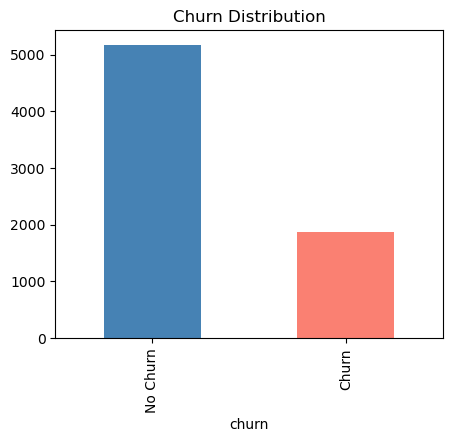

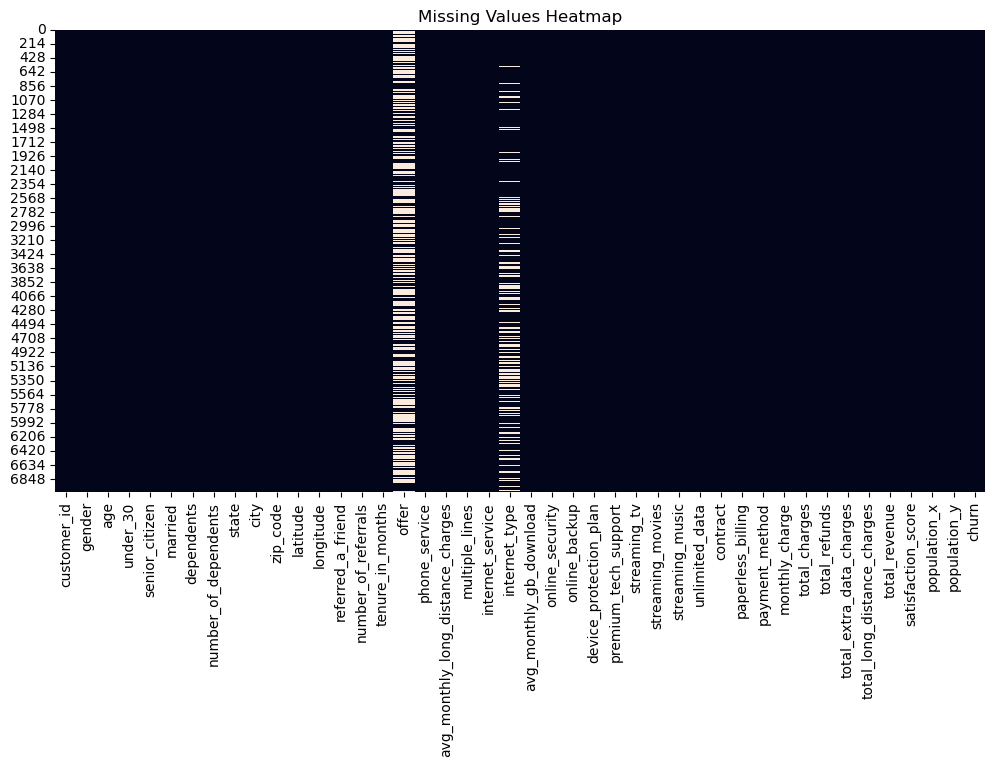

Numeric columns: 18
['age', 'number_of_dependents', 'latitude', 'longitude', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges', 'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue', 'satisfaction_score', 'population_x', 'population_y', 'churn']

Categorical columns: 26
['customer_id', 'gender', 'under_30', 'senior_citizen', 'married', 'dependents', 'state', 'city', 'zip_code', 'referred_a_friend', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method']


In [32]:
# 4.1 Basic EDA: overview

import seaborn as sns
import matplotlib.pyplot as plt

# 1) Churn distribution
plt.figure(figsize=(5,4))
df["churn"].value_counts().plot(kind="bar", color=["steelblue", "salmon"])
plt.title("Churn Distribution")
plt.xticks([0, 1], ["No Churn", "Churn"])
plt.show()

# 2) Missing value heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# 3) Identify numeric vs categorical columns
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric columns:", len(numeric_cols))
print(numeric_cols)
print("\nCategorical columns:", len(categorical_cols))
print(categorical_cols)


- We have 18 numerical columns and 26 categorical columns

3.3.2 Churn rate by categorical variables

In [35]:
import warnings
warnings.filterwarnings("ignore")


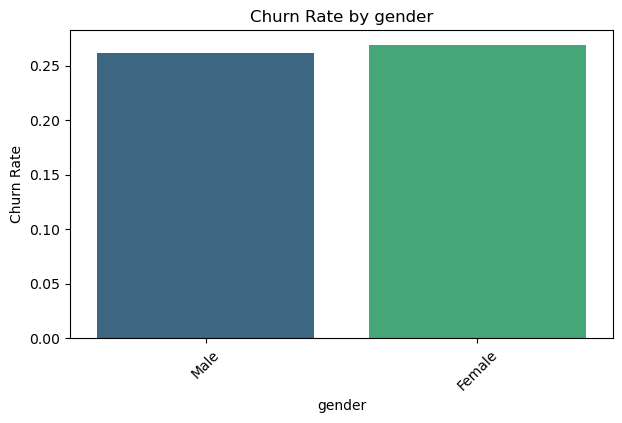

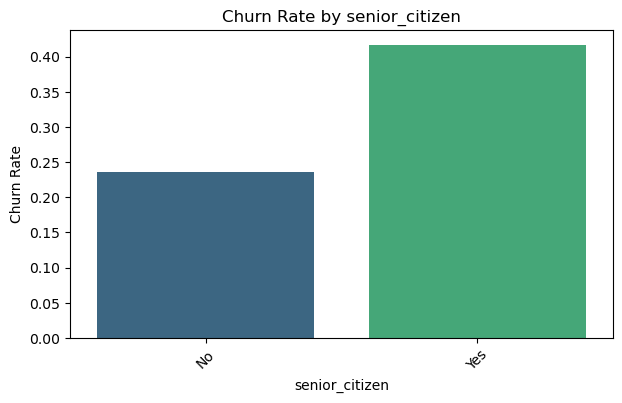

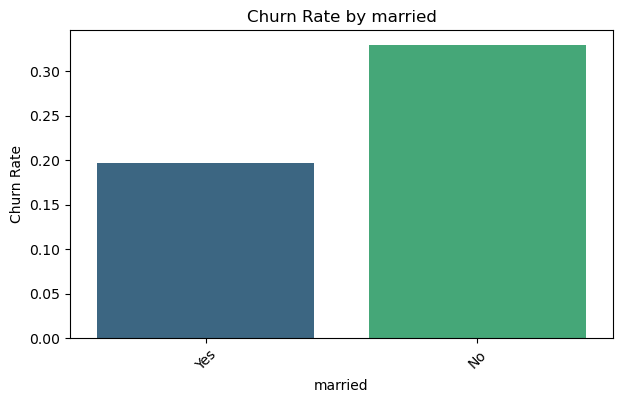

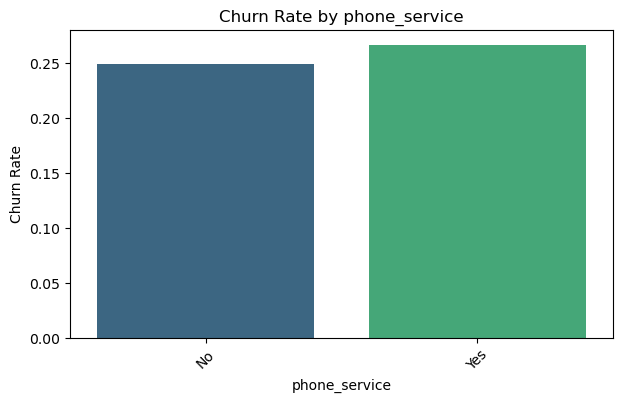

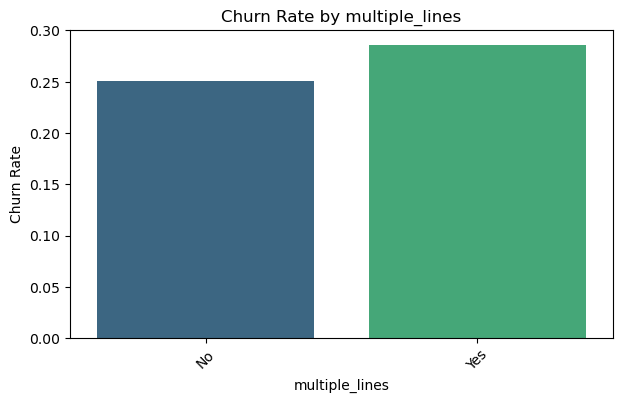

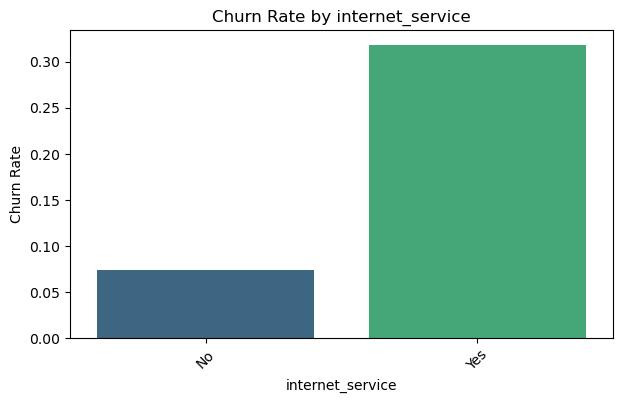

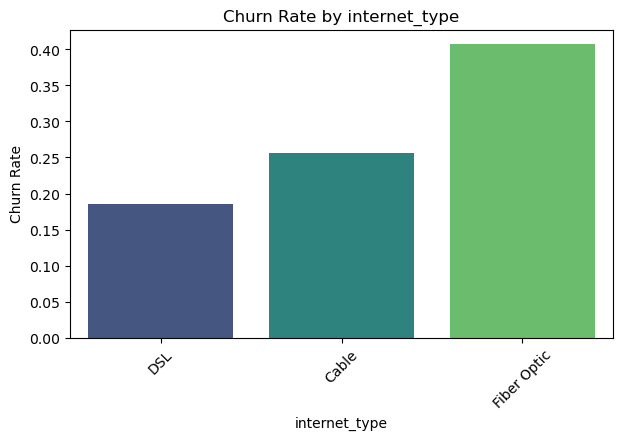

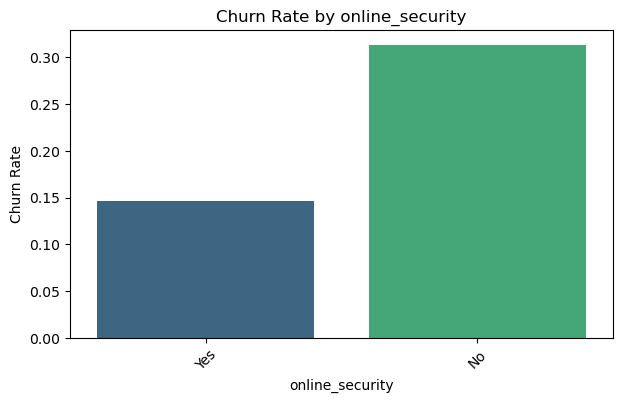

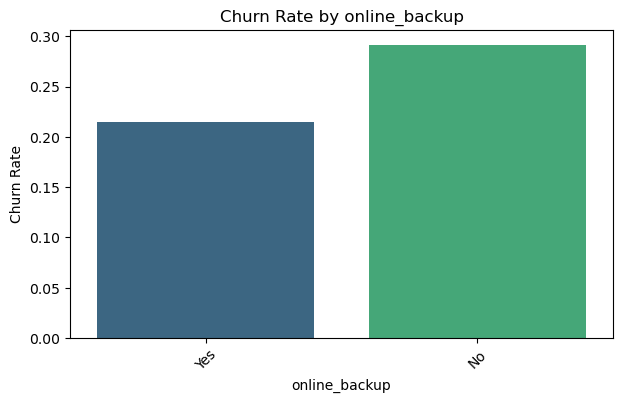

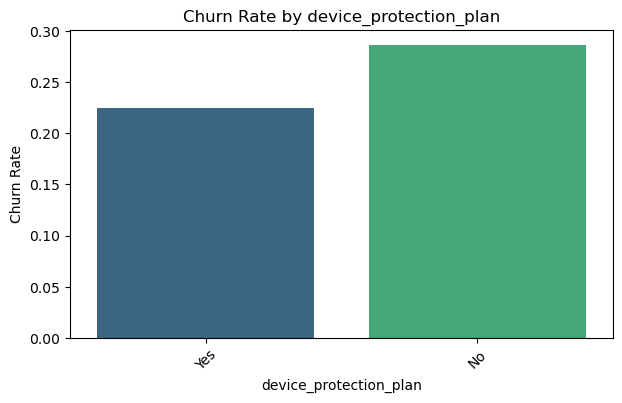

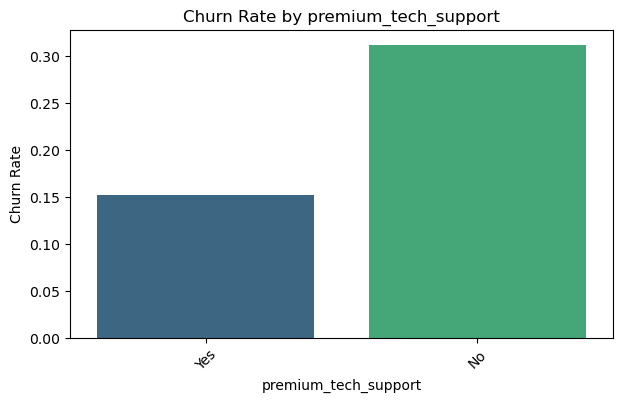

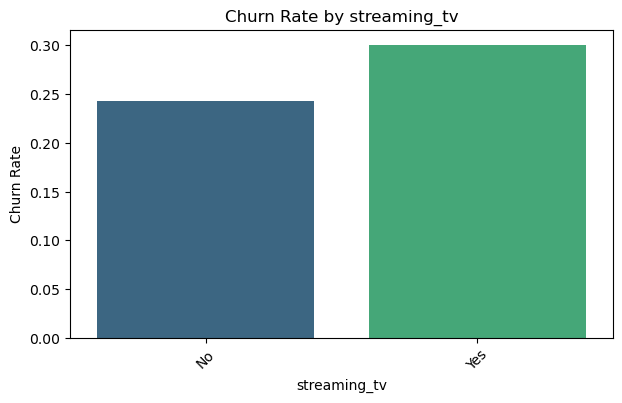

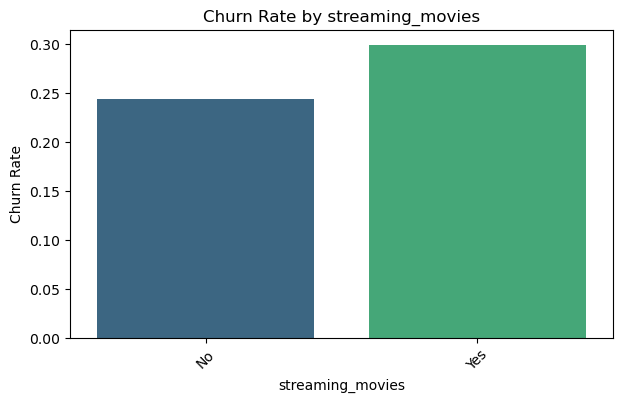

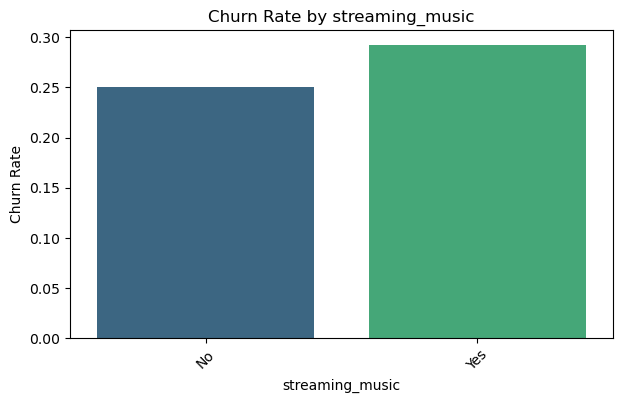

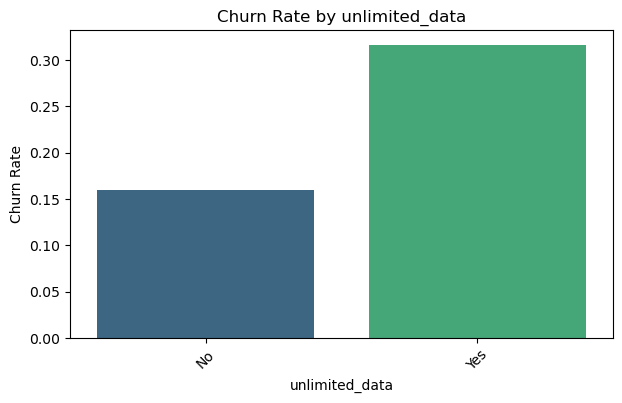

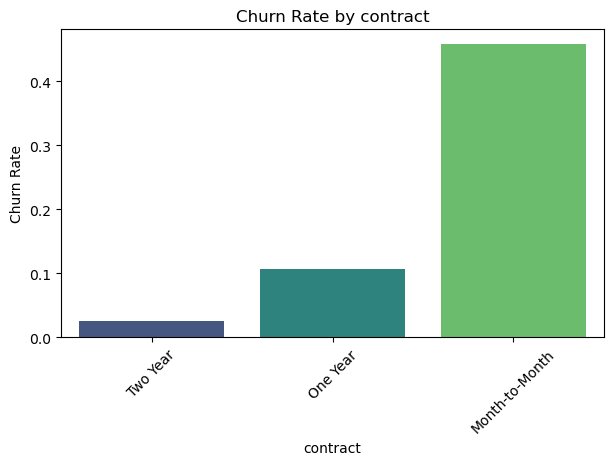

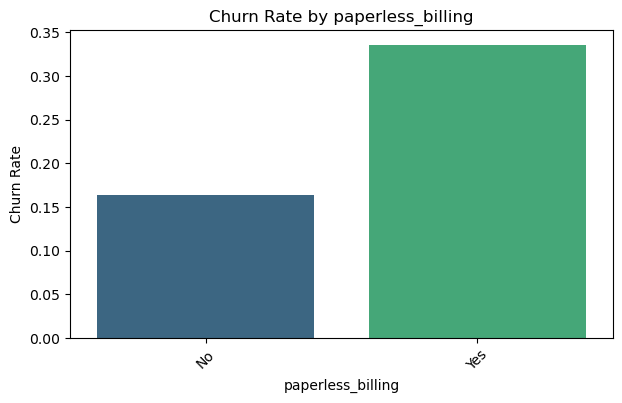

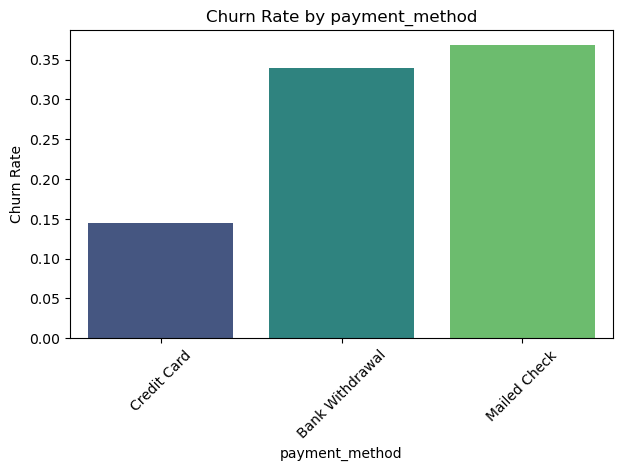

In [37]:
# 4.3 Churn rate by categorical features

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

cat_features_to_plot = [
    "gender",
    "senior_citizen",
    "married",
    "phone_service",
    "multiple_lines",
    "internet_service",
    "internet_type",
    "online_security",
    "online_backup",
    "device_protection_plan",
    "premium_tech_support",
    "streaming_tv",
    "streaming_movies",
    "streaming_music",
    "unlimited_data",
    "contract",
    "paperless_billing",
    "payment_method",
]

for col in cat_features_to_plot:
    if col in df.columns:
        plt.figure(figsize=(7,4))
        churn_rate = df.groupby(col)["churn"].mean().sort_values()
        sns.barplot(x=churn_rate.index, y=churn_rate.values, palette="viridis")
        plt.title(f"Churn Rate by {col}")
        plt.ylabel("Churn Rate")
        plt.xlabel(col)
        plt.xticks(rotation=45)
        plt.show()


- **Churn by categorical variables Key Insights:**

High Impact Variables:

**Contract Type:**

By far the strongest categorical driver.

Month-to-month customers have very high churn (~40%)

One-year contracts have low churn (~10%)

Two-year contracts have almost zero churn (~5%)

Interpretation: The lack of contract commitment strongly predicts churn.
Business action: Incentivize contract renewal, bundling, loyalty discounts.

-------------------------------------------------------------------------------------

**Internet Type / Internet Service:**

Fiber Optic customers churn the most (~40%)

Cable has medium churn

DSL has the lowest churn

Indicates service quality issues in Fiber or competitive pressure.


-------------------------------------------------------------------------------------

**Security & Support Add-ons**

Highly predictive:

Customers without Online Security churn significantly more

Customers without Tech Support churn significantly more

Same pattern with Online Backup, Device Protection, etc.

These add-ons are retention protectors.
Customers without them are higher risk.

Business implication: Offer discounts or free trials of security/support features to high-risk segments.


-------------------------------------------------------------------------------------

**Payment Method**

Mailed check and bank withdrawal churn the most (~35–40%)

Credit card has the lowest churn (~15%)

Suggests customers using “modern & automatic” payment methods are more stable.

Encourage switching to credit card or auto-pay.


-------------------------------------------------------------------------------------

**Paperless Billing**

Paperless billing = higher churn

Non-paperless billing = lower churn

This is often linked to:

month-to-month subscription overlaps

digital engagement risk

customers who are “less tied” to the company

**Summary:**

Churn is primarily driven by service commitment, internet technology, and the presence of support/security add-ons.
Month-to-month customers, fiber optic users, and customers lacking security or tech-support services exhibit the highest churn rates.
Payment mode and digital engagement behaviors (paperless billing) also correlate strongly with higher churn.
Less impactful variables include gender, phone service, and marital status.

**Strong predictors — KEEP and use in modeling:**

- contract

- internet_type / internet_service

- online_security

- premium_tech_support

- online_backup

- device_protection_plan

- payment_method

- paperless_billing

- senior_citizen

- unlimited_data

- streaming_* features

- tenure_in_months (numeric but critical)

**Weak predictors — LOW priority:**

- gender

- married

- dependents

- referred_a_friend



3.3.3 Churn Vs Tenure & Monthly Charges 

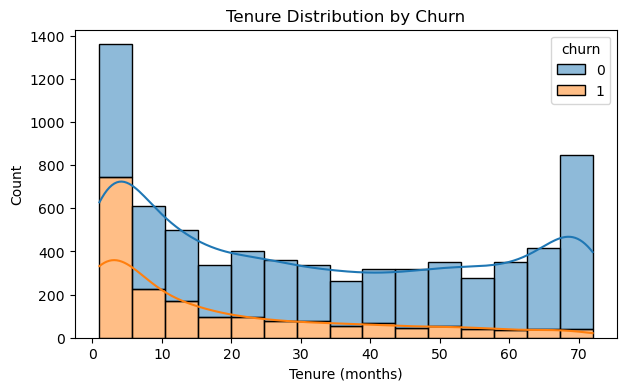

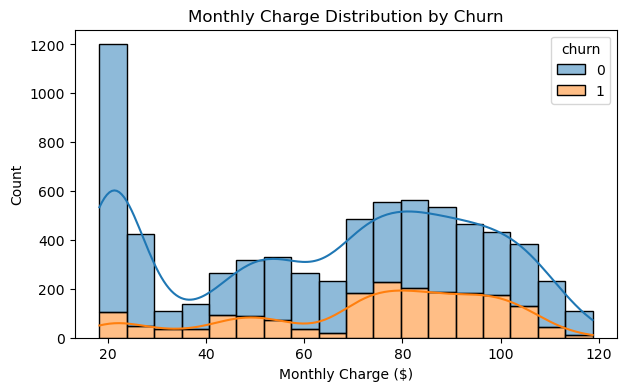

In [38]:
# 4.4 Churn vs numeric drivers

import seaborn as sns
import matplotlib.pyplot as plt

# TENURE vs CHURN
plt.figure(figsize=(7,4))
sns.histplot(data=df, x="tenure_in_months", hue="churn", kde=True, multiple="stack")
plt.title("Tenure Distribution by Churn")
plt.xlabel("Tenure (months)")
plt.ylabel("Count")
plt.show()

# MONTHLY CHARGE vs CHURN
plt.figure(figsize=(7,4))
sns.histplot(data=df, x="monthly_charge", hue="churn", kde=True, multiple="stack")
plt.title("Monthly Charge Distribution by Churn")
plt.xlabel("Monthly Charge ($)")
plt.ylabel("Count")
plt.show()


**Key Insights:**

**Tenure**

Early lifecycle churn spike → onboarding problem

Long-tenure customers stable → no need to spend retention budget here

Main risk zone: first 90 days

**Monthly Charges**

High-paying customers churn more → price-performance dissatisfaction

Mid-range customers most loyal

Low-paying customers stable legacy users

**Interaction**

The most critical churn profile is:
Fiber + High charges + No security/tech support + Low tenure

This is out high-value, high-risk customer segment.

